### Importing Packages

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sep 2021
@author: Darshan
"""

### For Removing the Warnings 
from warnings import filterwarnings
filterwarnings("ignore")

### basic packages for data operations
import pandas as pd
import numpy as np

### package for visualization
import matplotlib.pyplot as plt
import seaborn as sns

### packages for preprocessing, splitting and for measuring the performance 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report

###packages for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

### Data Transformation Functions

In [2]:
### Function for reading the data
def read_data(filename):
    """
    Purpose : Reading the data from .txt format
    input   : filename
    output  : DataFrame
    """
    f = open(path+filename, "r")
    data = f.readlines()
    df = []
    for i in range(len(data)):
        df.append(data[i].replace("\t"," ").replace("\n","").split(" "))
    df_final = pd.DataFrame(df)
    return df_final 

### Function to rename the columns
def renamer(dataFrame, columns):
    """
    Purpose : Renaming the columns
    input   : DataFrame, column_name list
    output  : DataFrame with columns renamed
    """
    dataFrame.columns = columns
    return dataFrame

def date_cleaner(dataFrame):
    """
    Purpose : joining the date and time columns and deleting the time column
    input   : DataFrame
    output  : DataFrame with timestamp
    """
    dataFrame[0] = dataFrame[0]+" "+dataFrame[1]
    dataFrame.drop(1,axis = 1, inplace = True)
    return dataFrame

def feature_generator(data, index, values, func='count'):
    """
    purpose : Aggragating the data using function with index level
    input   : DataFrame, index, values, aggregation function
    output  : DataFrame
    """
    data = pd.pivot_table(data, 
                          index= index, 
                          values = values,
                          aggfunc=func).reset_index()
    return data

def label_generator(dataFrame):
    """
    Purpose : to calculate the avg of visits per each user and encoding the visited section value.
    input   : DataFrame
    output  : DataFram with average visits and long to wide conversion.
    """
    ### Calculating the total no of actions per user
    dataFrame_total = dataFrame.groupby(['UserID']).agg({"visitecount":"sum"}).reset_index().rename(columns = {"visitecount":"total_visits"})

    ### Joining the total values to the base data 
    dataFrame = dataFrame.merge(dataFrame_total, on=['UserID'], how = 'left')

    ### Calculating the share for the visits
    dataFrame['avg'] = dataFrame['visitecount']/dataFrame['total_visits']

    ### Encoding the labels
    ### declaring the encoding object
    enc = LabelEncoder()

    ### encoding the labels 
    dataFrame['label_code'] = enc.fit_transform(dataFrame['sectionvisited'])

    ### Generating the dummy values for transformation
    dataFrame = pd.get_dummies(dataFrame,columns=['sectionvisited'],prefix="",prefix_sep="")
    
    return dataFrame, enc

def weight_assigner(dataFrame, enc, target_value):
    """
    Purpose : Multiplying the average to respective column
    input   : DataFrame
    output  : returns DataFrame after multiplying the avg to respective column
    """
    # Declaring the blank dataframe
    dds = pd.DataFrame()
    
    # looping the user id
    for userID in df_not_purchased_transformed.UserID.unique()[:1000]:
        # filtering the dataframe for perticulat user id
        dframe = df_not_purchased_transformed[df_not_purchased_transformed['UserID']==userID]
        # looping the each label  from the filter dataframe
        for label in dframe.label_code:
            # filtering the dataframe to perticular label
            dframe_granlr = dframe[dframe['label_code']==label]
            # assining the avg to value variable
            value = dframe_granlr['avg']
            # looping each column and multipling the value
            for col in enc.classes_:
                if dframe_granlr[col].values==1:
                    dframe_granlr[col] = value
                    # append the data to main dataframe
                    dds = pd.concat([dds,dframe_granlr],axis=0)

    dds.drop(['visitecount','total_visits','avg','label_code'], axis=1, inplace = True)
    dds = dds.groupby(["UserID"]).sum().reset_index()
    # adding the target variable 
    dds['target'] = target_value
    
    return dds

### Model Experimenting Function

In [3]:
def run_exps(X_train , y_train, X_test, y_test):
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
                ('LDA', LinearDiscriminantAnalysis()),
                ('ADA', AdaBoostClassifier()),
                ('LR', LogisticRegression()), 
                ('RF', RandomForestClassifier()),
                ('KNN', KNeighborsClassifier()),
                ('SVM', SVC()), 
                ('GNB', GaussianNB()),
                ('XGB', XGBClassifier()),
              ]
    
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['0','1']
    for name, model in models:
            kfold = model_selection.KFold(n_splits=8, shuffle=True, random_state=90)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            print(name)
            print(classification_report(y_test, y_pred, target_names=target_names))
            
            results.append(cv_results)
            names.append(name)
            
            this_df = pd.DataFrame(cv_results)
            this_df['model'] = name
            dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

### Data Reading

In [4]:
### Root Directory
path = "C:/Users/DarshanMU/Downloads/Problem/Datasets/"

### Reading the conversion data
file1 = "Problem2_FInalConversions"
df_conversions = read_data(file1)

### Reading site behavior data
file2 = 'Problem2_Site_BrowingBehavior'
df_sitebb = read_data(file2)

### Data Preprocessing

In [5]:
### Cleaning the time stamp
df_conversions_cleaned = date_cleaner(df_conversions)
df_sitebb_cleaned      = date_cleaner(df_sitebb)

### Renaming the columns
columns_conversions = ["Timestamp", "UserID", "ProductsPurchased", "OverallCartValue"]
columns_bb = ["Timestamp", "UserID","sectionvisited"]

df_conversions_cleaned = renamer(df_conversions_cleaned, columns_conversions)
df_sitebb_cleaned = renamer(df_sitebb_cleaned, columns_bb)

### Converting the timestamp to datetime format
df_conversions_cleaned["Timestamp"] = pd.to_datetime(df_conversions_cleaned["Timestamp"])
df_sitebb_cleaned["Timestamp"]      = pd.to_datetime(df_sitebb_cleaned["Timestamp"])

### Feature Engineering

In [158]:
### Filter the behavioural data using conversion data for futher operations.
df_not_purchased = df_sitebb_cleaned[~(df_sitebb_cleaned['UserID'].isin(df_conversions_cleaned['UserID'].unique()))]
df_purchased     = df_sitebb_cleaned[(df_sitebb_cleaned['UserID'].isin(df_conversions_cleaned['UserID'].unique()))]

### Declearing the variables for aggregation operation
index = ["UserID","sectionvisited"]
values = "sectionvisited"
func = 'count'

### Function call for aggregating the data
df_not_purchased_trans = feature_generator(df_not_purchased, index, values, func)
df_not_purchased_trans = df_not_purchased_trans.rename(columns={"Timestamp":"visitecount"})

df_purchased_trans = feature_generator(df_purchased, index, values, func)
df_purchased_trans = df_not_purchased_trans.rename(columns={"Timestamp":"visitecount"})

### calling function to get the visits share per user and then long to wide conversion of section visited
df_not_purchased_transformed, enc_not_purchased = label_generator(df_not_purchased_trans)
df_purchased_transformed, enc_purchased = label_generator(df_purchased_trans)

df_not_purchased_final = weight_assigner(df_not_purchased_transformed, enc_not_purchased, 0)
df_purchased_final     = weight_assigner(df_purchased_transformed, enc_purchased, 1)

### concating the purchased and not purchased 
df_final = pd.concat([df_not_purchased_final,df_purchased_final], axis=0)

### filling the null values
df_final = df_final.fillna(0)

### Final Data Spliting & Normalizing 

In [7]:
### split the values to train and test

X_train, X_test, y_train, y_test = train_test_split(df_final.drop(['UserID','target'], axis=1).fillna(0), df_final['target'].fillna(0), test_size = 0.2, random_state = 42)

### Normalizing the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modeling Experiment

In [8]:
### Printing the models result
results = run_exps(X_train , y_train, X_test, y_test)

LDA
              precision    recall  f1-score   support

           0       0.72      0.92      0.80      1981
           1       0.89      0.64      0.75      2019

    accuracy                           0.78      4000
   macro avg       0.80      0.78      0.78      4000
weighted avg       0.80      0.78      0.78      4000

ADA
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1981
           1       0.91      0.85      0.88      2019

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

LR
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1981
           1       0.91      0.71      0.80      2019

    accuracy                           0.82      4000
   macro avg       0.84      0.82      0.82      4000
weighted avg       0.84      0.82      0.82      4000

RF
     

In [9]:
### This result set helps to analyze the individual model output
results[results['model']=='LDA']

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.566589,0.007994,0.7890,0.805417,0.7890,0.785414,0.857224,LDA
1,0.058997,0.008002,0.7740,0.789899,0.7740,0.769739,0.860636,LDA
2,0.052998,0.009002,0.7905,0.808922,0.7905,0.786983,0.866495,LDA
3,0.054991,0.009999,0.7865,0.804743,0.7865,0.782972,0.857109,LDA
4,0.051003,0.010001,0.7935,0.812741,0.7935,0.789895,0.871397,LDA
5,0.056001,0.016005,0.7880,0.812748,0.7880,0.783919,0.869872,LDA
6,0.058025,0.011971,0.8030,0.818069,0.8030,0.801023,0.874848,LDA
7,0.057002,0.015339,0.7715,0.801720,0.7715,0.767566,0.854201,LDA


In [10]:
final = results.copy()
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

### Models Output visualization

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

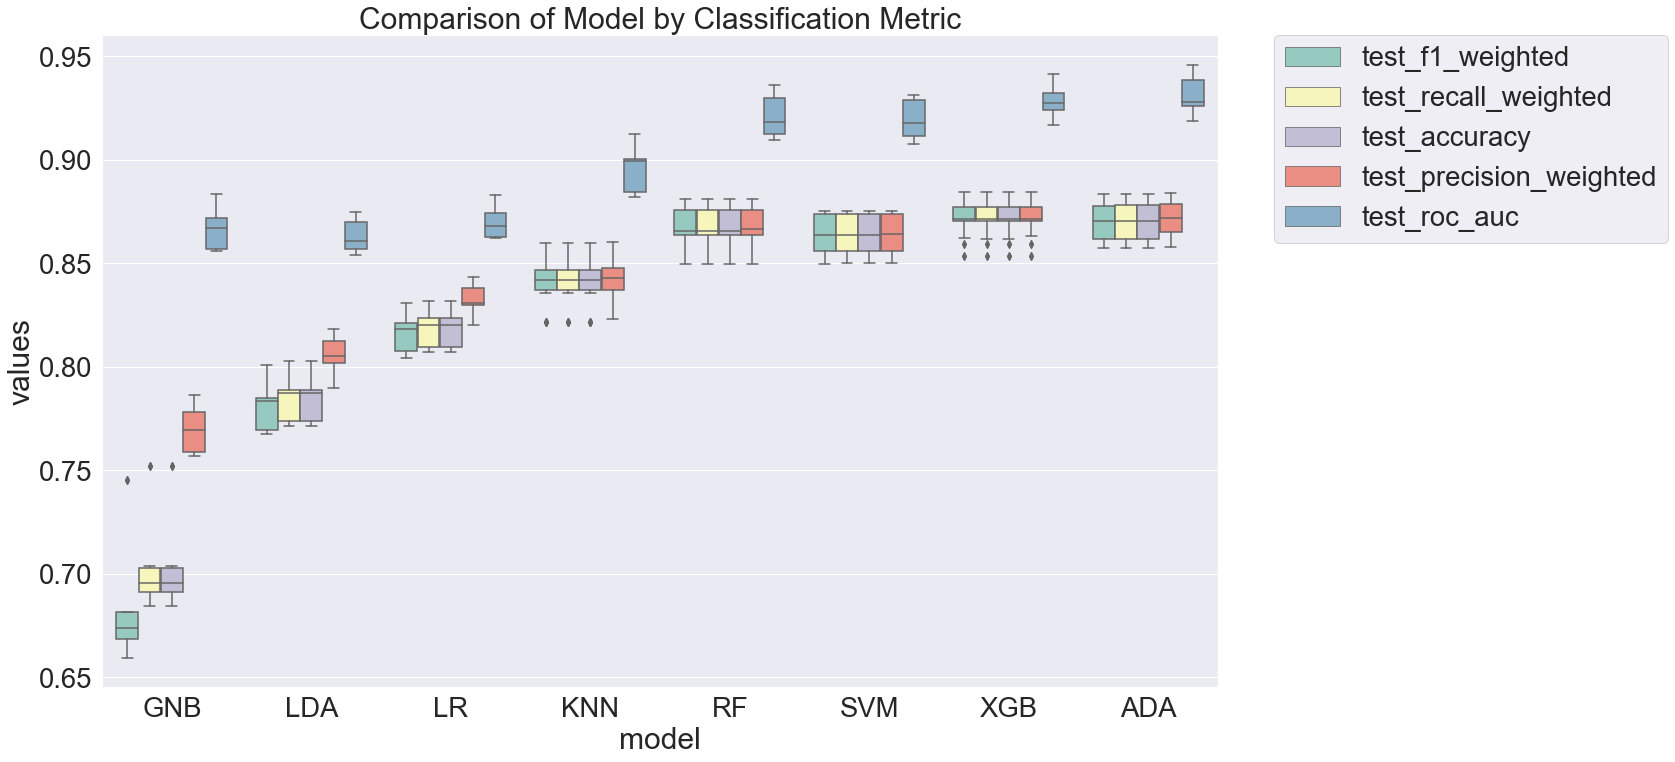

In [11]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

In [12]:
### Model outputs withh Mean and Std deviation which helps in analyzing the output
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_weighted           test_accuracy            \
                          std      mean           std      mean   
model                                                             
ADA                  0.008613  0.871639      0.008704  0.870967   
GNB                  0.009987  0.769714      0.018919  0.700167   
KNN                  0.010832  0.841784      0.011275  0.841000   
LDA                  0.009497  0.804534      0.009419  0.784650   
LR                   0.006575  0.833276      0.008370  0.818817   
RF                   0.008910  0.868058      0.008974  0.867917   
SVM                  0.008744  0.864683      0.008847  0.864333   
XGB                  0.008632  0.871686      0.008768  0.871550   

      test_recall_weighted           test_roc_auc           test_f1_weighted  \
                       std      mean          std      mean              std   
model                                                                          
ADA               0.008704  0.870967     0.008638  0.931957         0.008728   
GNB               0.018919  0.700167     0.009381  0.866822         0.023675   
KNN               0.011275  0.841000     0.009840  0.895534         0.011277   
LDA               0.009419  0.784650     0.006948  0.862885         0.009944   
LR                0.008370  0.818817     0.007605  0.870249         0.008633   
RF                0.008974  0.867917     0.009431  0.921191         0.008969   
SVM               0.008847  0.864333     0.008715  0.919078         0.008861   
XGB               0.008768  0.871550     0.007308  0.928608         0.008758   

                 
           mean  
model            
ADA    0.870892  
GNB    0.679468  
KNN    0.840986  
LDA    0.780926  
LR     0.816889  
RF     0.867920  
SVM    0.864307  
XGB    0.871560

### Model Selection

In [13]:
### Based on the above results, we are choosing ADA, RF, SVM, XGB models for ensemble

In [14]:
model = AdaBoostClassifier( base_estimator=None,
                            n_estimators=1000,
                            learning_rate=1.3,
                            algorithm='SAMME.R',
                            random_state=50)

model.fit(X_train, y_train)
print(f"training accuracy:",model.score(X_train, y_train)*100)
print(f"testing accuracy:",model.score(X_test, y_test)*100)

training accuracy: 87.6375
testing accuracy: 88.05


In [15]:
### Model Confusion matrix
y_predicted = model.predict(X_test)
pd.crosstab(y_test, y_predicted,colnames=["Predicted"],rownames=["Target"])

Predicted,0,1
Target,,
0,1785,196
1,282,1737


In [16]:
### Classification Report of the final model
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1981
           1       0.90      0.86      0.88      2019

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



### Scope of Imporovement

    * Feature Engineering :
        - Adding the weight to the visited section along with the mean time of that section which user spent.
    * Modelling Experiment :
        - Analyzing the variable importance and removing the variables according to that and then running the modelling experiments.
        - Running the hyperparameter tuning for each model in the experiment.
        - Building and fine tuning state - of - art Neural Network classifiers. 
    * Final Model Selection :
        - Selecting more models with high roc_auc values and buliding the voting classifier(Extra Ensemble technique).
        - Performing the hyperparameter tuning.